In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab.patches import cv2_imshow
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing required python libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
from skimage import io
from skimage.io import imread
import os
from glob import glob
import h5py
%matplotlib inline 
import re
import time
import warnings
import random
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import normalized_mutual_info_score
warnings.filterwarnings("ignore")
# Create images with white backgrounds
import plotly.io as pio
pio.templates.default = 'plotly_white'
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

import cv2
import tensorflow 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.nasnet import NASNetMobile # NASNetMobile
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Softmax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras import losses

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


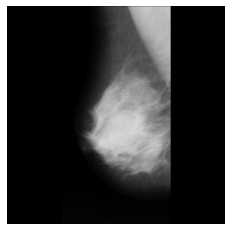

In [ ]:
def plot_a_mammography_image(ref_num):
  file_path = os.path.join('.', 'drive', 'MyDrive', 'BreastCancer_Project', 'mammography_images', ref_num + '.pgm')
  img = cv2.imread(file_path, 1)
  plt.axis('off')
  plt.imshow(img)

plot_a_mammography_image('mdb001')

In [ ]:
# read image data and agument the data

def get_img_data(ref_no):

    file_path = os.path.join('.', 'drive', 'MyDrive', 'BreastCancer_Project', 'mammography_images', str(ref_no) + '.pgm')
    img = cv2.imread(file_path, 1)
    img = cv2.resize(img, (224, 224))
    rows, cols, color = img.shape
    
    # augment the image data by rotations, transorformations
    
    total_angle = 360
    data = {}
    for angle in range(0, total_angle, 8):
        matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1) # at center of image rotate and scale it by 1
        img_rotated = cv2.warpAffine(img, matrix, (cols, rows))
        data[angle] = img_rotated
    return data

In [ ]:
def get_label(severity):
    if severity == 'B':
        return 2
    elif severity == 'M':
        return 1
    else:
        return 0

def get_severity(label):
  if label == 2:
    return 'B'
  elif label == 1:
    return 'M'
  else:
    return 0

In [ ]:
info_file_path = os.path.join('.', 'drive', 'MyDrive', 'BreastCancer_Project', 'mammography_images', 'info.txt')
info_df = pd.read_csv(info_file_path, sep=" ")
info_df = info_df.drop('Unnamed: 7',axis=1)
info_df['SEVERITY_LABEL'] = info_df.apply(lambda x: get_label(x['SEVERITY']), axis = 1)
info_df.head()

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS,SEVERITY_LABEL
0,mdb001,G,CIRC,B,535.0,425.0,197.0,2
1,mdb002,G,CIRC,B,522.0,280.0,69.0,2
2,mdb003,D,NORM,NaN,NaN,NaN,NaN,0
3,mdb004,D,NORM,NaN,NaN,NaN,NaN,0
4,mdb005,F,CIRC,B,477.0,133.0,30.0,2


In [ ]:

print('Total images: ', info_df['REFNUM'].count())
img_data = []

for ref in list(info_df['REFNUM']):
    img_data += get_img_data(ref).values()

print('Total Images after augumenting: ', len(img_data))

Total images:  330
Total Images after augumenting:  14850


In [ ]:
total_angle = 360
label_data = []
for r in list(info_df['REFNUM']):
    val = info_df.loc[info_df['REFNUM'] == r, 'SEVERITY_LABEL'].iloc[0]
    for angle in range(0, total_angle, 8):
        label_data.append(val)

# convert into numpy arrays
label_data = np.array(label_data)
img_data = np.array(img_data)

In [ ]:
# split train and test set
x_train, x_test, y_train, y_test = train_test_split(img_data, label_data, test_size = 0.2, random_state = 42)
len(x_train),len(x_test),len(y_train),len(y_test)
print(x_train.shape)

(11880, 224, 224, 3)


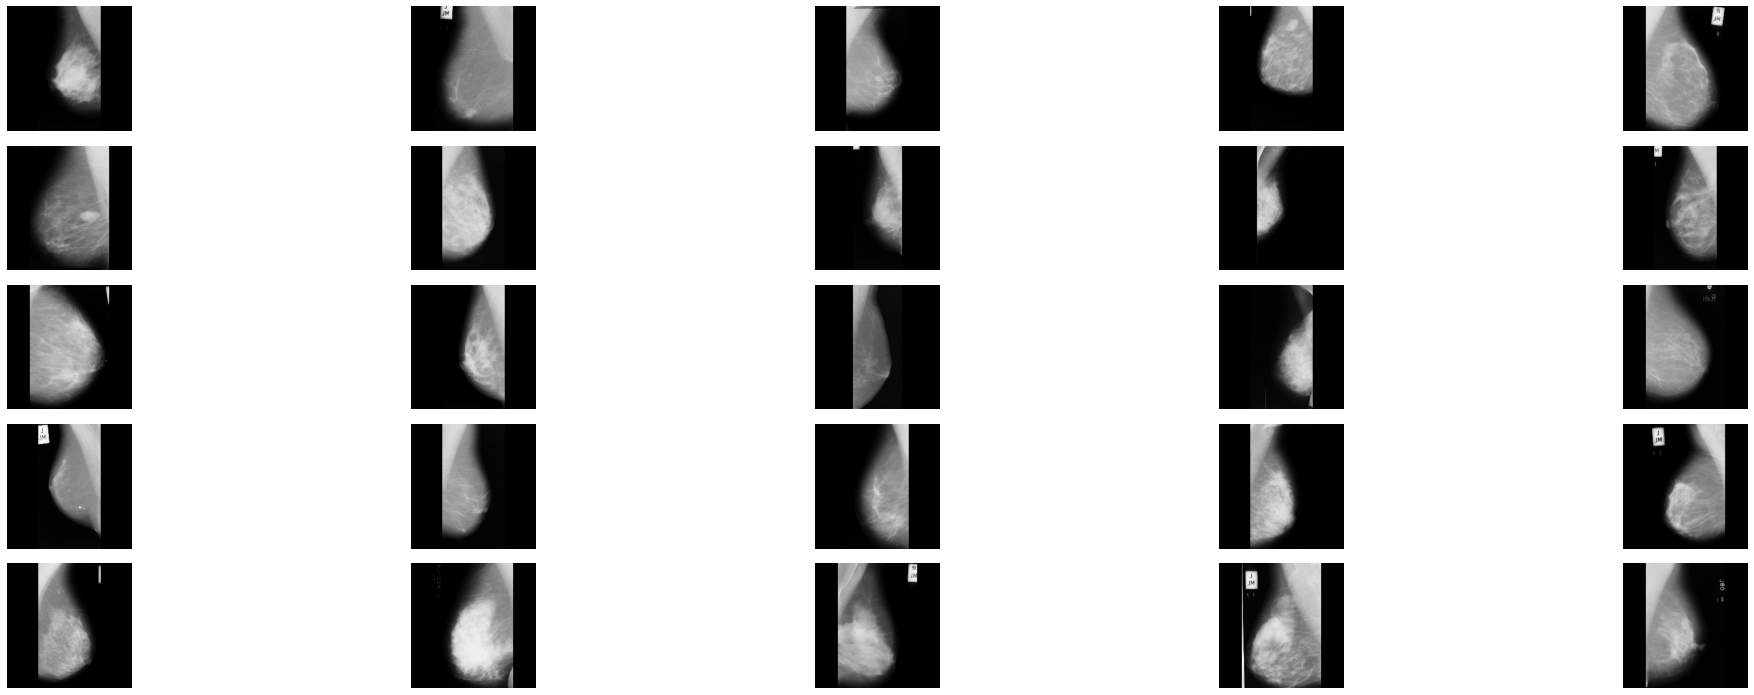

In [ ]:
# display 25 images
ref_numbers = info_df['REFNUM'].values
# print('ref numbers ', ref_numbers)
fig = plt.figure(figsize=(30, 10))
img_data_list = []
for i in ref_numbers:
    img_data_list.append(get_img_data(i)[0])
    
for i in range(25):
    rand = random.randint(0,len(img_data_list))
    ax = plt.subplot(5, 5, i+1)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(img_data_list[i * 5])
    

In [ ]:
# Using simple cnn model
cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3, 3) ,activation='relu', input_shape=(224, 224, 3)))
cnn_model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(BatchNormalization())

cnn_model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Flatten())
cnn_model.add(Dense(3, activation='softmax'))

print('Model Summary')
print(cnn_model.summary())

Model Summary
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 54, 54, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 54, 54

In [ ]:
es_cnn = EarlyStopping(monitor='val_loss', mode='min', patience=6, restore_best_weights=True, verbose=1)
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_history = cnn_model.fit(x_train, y_train, validation_split=0.15, shuffle=True, epochs=20, batch_size=128, callbacks=[es_cnn])
loss_value , accuracy = cnn_model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

# print(model.predict(x_test)) 
cnn_model.save('breast_cance_cnn_model.h5')

Epoch 1/100
79/79 [==============================] - 81s 553ms/step - loss: 1.4673 - accuracy: 0.5619 - val_loss: 1.0238 - val_accuracy: 0.5511
Epoch 2/100
79/79 [==============================] - 35s 447ms/step - loss: 0.9456 - accuracy: 0.6134 - val_loss: 1.0961 - val_accuracy: 0.4130
Epoch 3/100
79/79 [==============================] - 36s 461ms/step - loss: 0.9376 - accuracy: 0.6192 - val_loss: 1.0159 - val_accuracy: 0.5808
Epoch 4/100
79/79 [==============================] - 36s 452ms/step - loss: 0.9294 - accuracy: 0.6197 - val_loss: 1.0800 - val_accuracy: 0.4327
Epoch 5/100
79/79 [==============================] - 36s 456ms/step - loss: 0.9287 - accuracy: 0.6204 - val_loss: 0.9823 - val_accuracy: 0.6139
Epoch 6/100
79/79 [==============================] - 36s 455ms/step - loss: 0.9250 - accuracy: 0.6210 - val_loss: 0.9456 - val_accuracy: 0.6319
Epoch 7/100
79/79 [==============================] - 36s 454ms/step - loss: 0.9234 - accuracy: 0.6214 - val_loss: 0.9442 - val_accuracy:

In [ ]:
# helper method to predict class given a reference number and  a model
def predict_cancer(ref_num, tr_model):
  sample = np.array([get_img_data(ref)[0]])
  pred_class = tr_model.predict_classes(sample)[0]
  return get_severity(pred_class)

def comparision_plot(x1, x2, x1_label, x2_label, title):
  fig = plt.figure(figsize=(12, 8))
  ax = fig.add_subplot(111)
  plot1 = ax.plot(range(0, len(x1)), x1, label = x1_label)
  plot2 = ax.plot(range(0, len(x2)), x2, label = x2_label)

  ax.set(title = title, xlabel = 'epoch')
  ax.legend()

  # fig.suptitle('Model Progress with epochs ', fontsize = 20, fontweight = 'bold')
  fig.savefig(title + '.png')
  plt.tight_layout()
  plt.show()



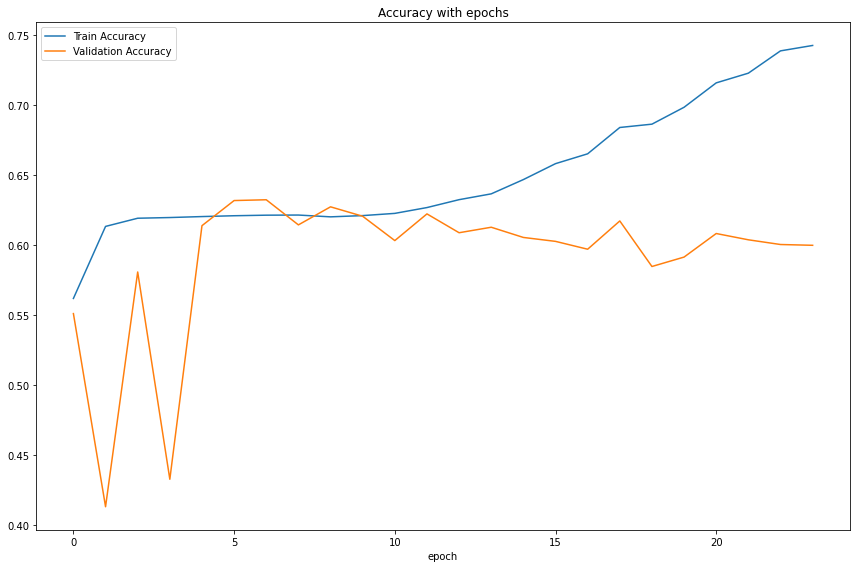

In [ ]:
comparision_plot(cnn_history.history['accuracy'], cnn_history.history['val_accuracy'], 'Train Accuracy', 'Validation Accuracy', 'Accuracy with epochs')

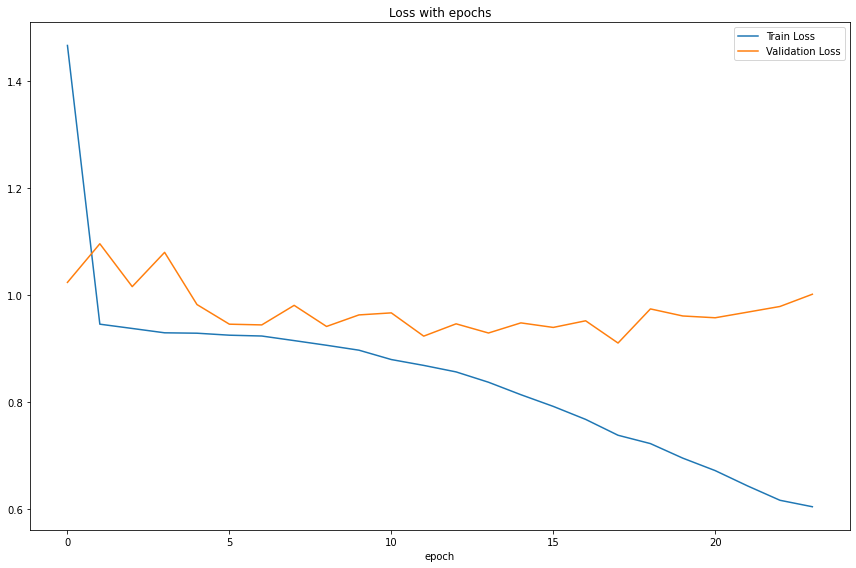

In [ ]:
# Train loss vs Cross validation loss
comparision_plot(cnn_history.history['loss'], cnn_history.history['val_loss'], 'Train Loss', 'Validation Loss', 'Loss with epochs')

In [ ]:
# will use vgg-19 model that is trained on imagenet data set:
# Transfer learning technique: add few later layers and train with our data

base_model = VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 25088)             100352    
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096      
_________________________________________________________________
activation (Activation)      (None, 1024)             

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=6, restore_best_weights=True, verbose=1)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_split=0.15, shuffle=True, epochs=25, batch_size=128, callbacks=[es])
loss_value , accuracy = model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

# print(model.predict(x_test)) 
model.save('breast_cance_model.h5')


Epoch 1/25
79/79 [==============================] - 125s 1s/step - loss: 0.9581 - accuracy: 0.6174 - val_loss: 1.1968 - val_accuracy: 0.6857
Epoch 2/25
79/79 [==============================] - 63s 798ms/step - loss: 0.3662 - accuracy: 0.8590 - val_loss: 0.6463 - val_accuracy: 0.7727
Epoch 3/25
79/79 [==============================] - 63s 804ms/step - loss: 0.1833 - accuracy: 0.9321 - val_loss: 0.3960 - val_accuracy: 0.8648
Epoch 4/25
79/79 [==============================] - 63s 801ms/step - loss: 0.1124 - accuracy: 0.9593 - val_loss: 0.3378 - val_accuracy: 0.8889
Epoch 5/25
79/79 [==============================] - 64s 807ms/step - loss: 0.0759 - accuracy: 0.9736 - val_loss: 0.3060 - val_accuracy: 0.9035
Epoch 6/25
79/79 [==============================] - 63s 805ms/step - loss: 0.0585 - accuracy: 0.9790 - val_loss: 0.2932 - val_accuracy: 0.9220
Epoch 7/25
79/79 [==============================] - 64s 807ms/step - loss: 0.0610 - accuracy: 0.9800 - val_loss: 0.3025 - val_accuracy: 0.9181
E

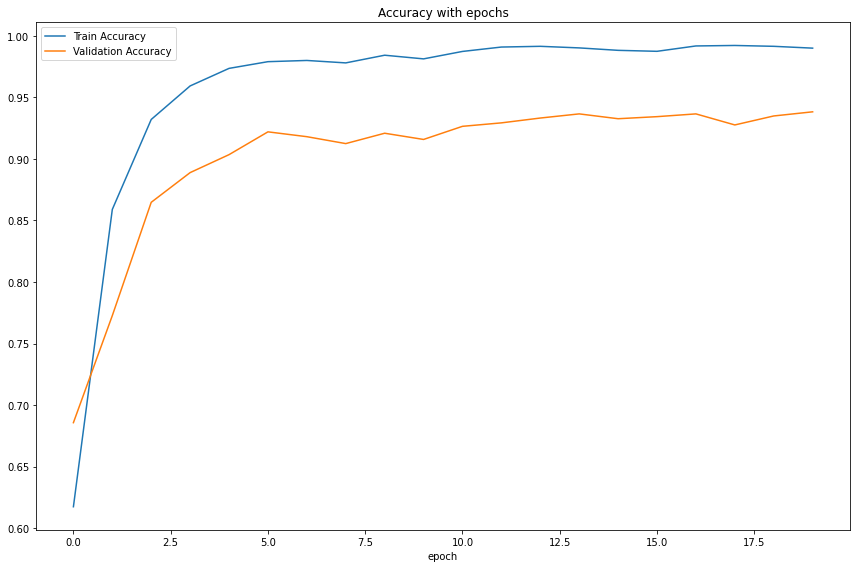

In [ ]:
comparision_plot(history.history['accuracy'], history.history['val_accuracy'], 'Train Accuracy', 'Validation Accuracy', 'Accuracy with epochs')

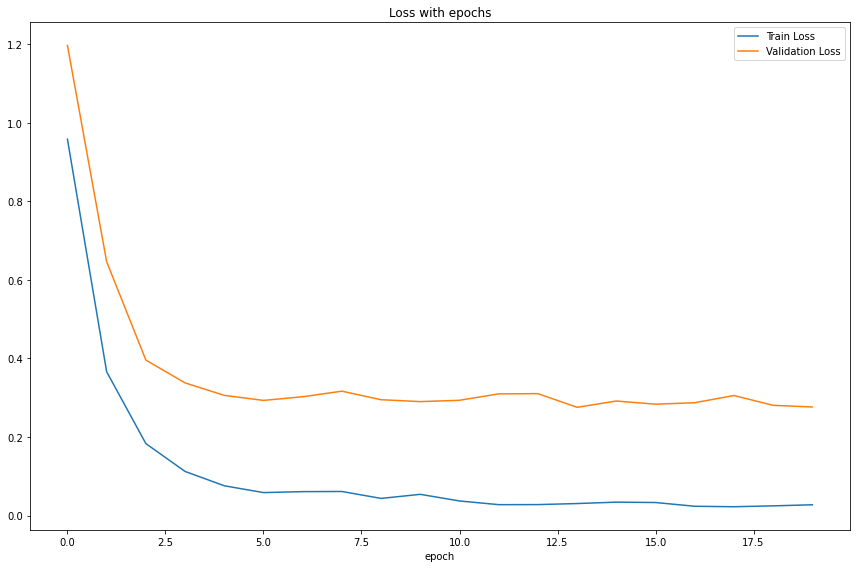

In [ ]:
# Train loss vs Cross validation loss
comparision_plot(history.history['loss'], history.history['val_loss'], 'Train Loss', 'Validation Loss', 'Loss with epochs')

model prediction:  B


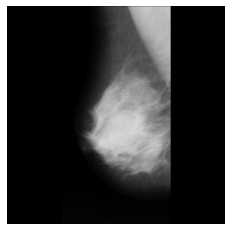

In [ ]:
# test the model with sample images

# B image
ref = info_df.loc[info_df['SEVERITY'] == 'B', 'REFNUM'].iloc[0]
plot_a_mammography_image(ref)
print('model prediction: ', predict_cancer(ref, model))

model prediction:  M


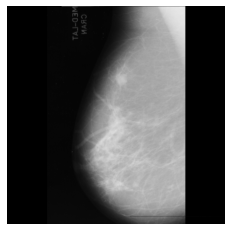

In [ ]:
# M image
ref = info_df.loc[info_df['SEVERITY'] == 'M', 'REFNUM'].iloc[0]
plot_a_mammography_image(ref)
print('model prediction: ', predict_cancer(ref, model))

model prediction:  0


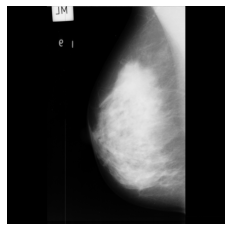

In [ ]:
# Normal image
ref = info_df.loc[info_df['SEVERITY_LABEL'] == 0, 'REFNUM'].iloc[0]
plot_a_mammography_image(ref)
print('model prediction: ', predict_cancer(ref, model))

In [ ]:
# using pre  trianed resnet model 
base_model = ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)
resnet_model = Sequential()
resnet_model.add(base_model)
resnet_model.add(Dropout(0.2))
resnet_model.add(Flatten())
resnet_model.add(BatchNormalization())
resnet_model.add(Dense(1024, kernel_initializer='he_uniform'))
resnet_model.add(BatchNormalization())
resnet_model.add(Activation('relu'))
resnet_model.add(Dropout(0.2))
resnet_model.add(Dense(1024, kernel_initializer='he_uniform'))
resnet_model.add(BatchNormalization())
resnet_model.add(Activation('relu'))
resnet_model.add(Dropout(0.2))
resnet_model.add(Dense(1024, kernel_initializer='he_uniform'))
resnet_model.add(BatchNormalization())
resnet_model.add(Activation('relu'))
resnet_model.add(Dropout(0.2))
resnet_model.add(Dense(3, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

resnet_model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
dropout_7 (Dropout)          (None, 7, 7, 2048)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 100352)            401408    
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              102761472 
_________________________________________________________________
batch_normalization_6 (Batch (None, 1024)              4096      
_______________________________________________________

In [ ]:
resnet_es = EarlyStopping(monitor='val_loss', mode='min', patience=6, restore_best_weights=True, verbose=1)
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
resnet_history = resnet_model.fit(x_train, y_train, validation_split=0.15, shuffle=True, epochs=15, batch_size=128, callbacks=[resnet_es])
loss_value , accuracy = resnet_model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

resnet_model.save('breast_cance_resent_model.h5')

Epoch 1/15
79/79 [==============================] - 52s 590ms/step - loss: 1.0317 - accuracy: 0.5941 - val_loss: 1.4820 - val_accuracy: 0.5314
Epoch 2/15
79/79 [==============================] - 41s 520ms/step - loss: 0.4472 - accuracy: 0.8247 - val_loss: 0.5846 - val_accuracy: 0.7750
Epoch 3/15
79/79 [==============================] - 41s 521ms/step - loss: 0.1651 - accuracy: 0.9422 - val_loss: 0.4163 - val_accuracy: 0.8681
Epoch 4/15
79/79 [==============================] - 41s 521ms/step - loss: 0.1031 - accuracy: 0.9630 - val_loss: 0.3629 - val_accuracy: 0.8889
Epoch 5/15
79/79 [==============================] - 41s 520ms/step - loss: 0.0770 - accuracy: 0.9706 - val_loss: 0.4038 - val_accuracy: 0.8805
Epoch 6/15
79/79 [==============================] - 41s 520ms/step - loss: 0.0537 - accuracy: 0.9813 - val_loss: 0.3904 - val_accuracy: 0.9052
Epoch 7/15
79/79 [==============================] - 41s 519ms/step - loss: 0.0484 - accuracy: 0.9850 - val_loss: 0.3877 - val_accuracy: 0.8895

In [ ]:
# path = os.path.join('.', 'breast_cance_resent_model.h5')
# resnet_model = tensorflow.keras.models.load_model(path)


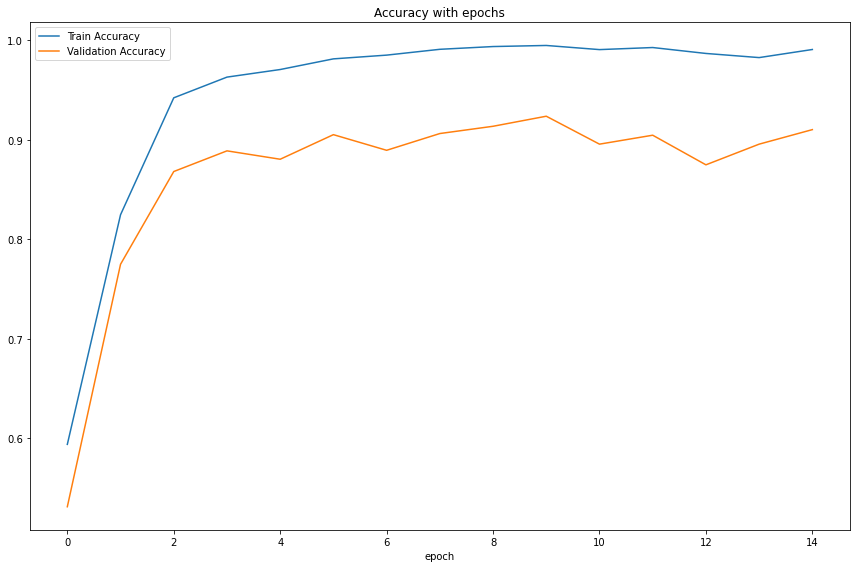

In [ ]:
comparision_plot(resnet_history.history['accuracy'], resnet_history.history['val_accuracy'], 'Train Accuracy', 'Validation Accuracy', 'Accuracy with epochs')

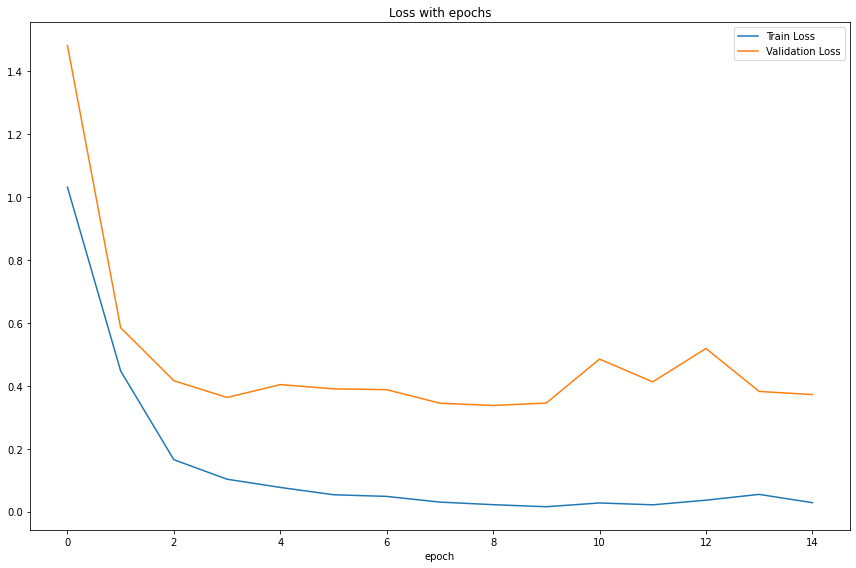

In [ ]:
comparision_plot(resnet_history.history['loss'], resnet_history.history['val_loss'], 'Train Loss', 'Validation Loss', 'Loss with epochs')

**Test with Sample Images**

model prediction:  B


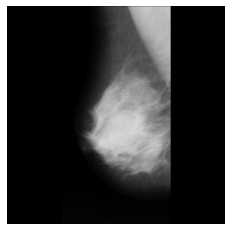

In [ ]:
# B image
ref = info_df.loc[info_df['SEVERITY'] == 'B', 'REFNUM'].iloc[0]
plot_a_mammography_image(ref)
print('model prediction: ', predict_cancer(ref, resnet_model))

model prediction:  M


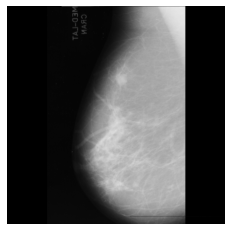

In [ ]:
# M image
ref = info_df.loc[info_df['SEVERITY'] == 'M', 'REFNUM'].iloc[0]
plot_a_mammography_image(ref)
print('model prediction: ', predict_cancer(ref, resnet_model))

model prediction:  0


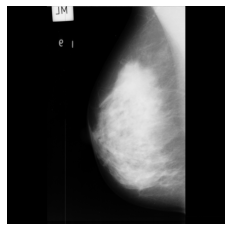

In [ ]:
# Normal image
ref = info_df.loc[info_df['SEVERITY_LABEL'] == 0, 'REFNUM'].iloc[0]
plot_a_mammography_image(ref)
print('model prediction: ', predict_cancer(ref, resnet_model))


**Ananlysis Summary**



*   Accuracy obtained on unseen data using self trained CNN netowork: 54.5%
*   Accuracy obtained using pretrained VGG19 model and adding additional layers: 91.8%
*   Accuracy obtained using pretrained ResNet50 model and adding additional layers: 92.8%



**How to improve the model performance**

*   Data plays a huge role to build a very powerful deep learning models whether we are building CNN's from sratch or using pretrained models like VGG19, ResNet50. Here we have tested with just 300 images and augumenting the image data but still achieved 92% accuracy. If we train with 10,000+ images and use the state of the art CNN architectures(like ResNet512, Inception network,..) and adding few more neural network layers we can build far more powerful models and achieve better accuracies.

